In [115]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchvision import datasets
from torchvision import transforms
from datetime import datetime

In [116]:
transformer_train = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomRotation(degrees=15),
  transforms.RandomAffine(0, translate=(0.1, 0.5)),
  transforms.ToTensor()                                            
])

In [117]:
batch_size = 48
CIFAR_train = datasets.CIFAR10(
    './data', download=True, transform=transformer_train)
CIFAR_test = datasets.CIFAR10(
    './data', download=True, train=False, transform=transformer_train)

train_loader = torch.utils.data.DataLoader(dataset=CIFAR_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=CIFAR_test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

train_dataset_fixed = datasets.CIFAR10(
    root='./data',
    train=True,
    transform=transforms.ToTensor(),
    download=True) 
train_loader_fixed = torch.utils.data.DataLoader(
    dataset=train_dataset_fixed,
    batch_size=batch_size,
    shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [118]:
def calculate_shapeHW(size, kernel_size, stride=1, padding=0, dilation=1):
    if type(size) == int:
        size = (size, size)
    if type(kernel_size) == int:
        kernel_size = (kernel_size, kernel_size)
    if type(stride) == int:
        stride = (stride, stride)
    if type(padding) == int:
        padding = (padding, padding)
    if type(dilation) == int:
        dilation = (dilation, dilation)
    x = int((size[0] + 2 * padding[0] - dilation[0] * (kernel_size[0]-1) -1)/stride[0] +1)
    y = int((size[1] + 2 * padding[1] - dilation[1] * (kernel_size[1]-1) -1)/stride[1] +1)
    return x, y


In [119]:
print(len(CIFAR_train.targets))
print((CIFAR_train.data.shape))

50000
(50000, 32, 32, 3)


In [120]:
out = calculate_shapeHW(32, kernel_size=3, padding=1)
out = calculate_shapeHW(32, kernel_size=2, stride=2, padding=0, dilation=1)
out

(16, 16)

In [121]:
class CNN(nn.Module):
    def __init__(self,input_size,output_size,pix_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_size, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )
        pix_size = int(pix_size/(2**3))
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128 * pix_size * pix_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, output_size)
        )

    def forward(self, input):
        output = self.conv1(input)
        output = self.conv2(output)
        output = self.conv3(output)
        output = output.view(output.size(0),-1)
        output = self.fc(output)
        return output

In [122]:
output_size = len(set(CIFAR_train.targets))
model = CNN(3,output_size,32)

In [123]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [124]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [125]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # print("inputs.shape:", inputs.shape)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      # print("about to get model output")
      outputs = model(inputs)
      # print("done getting model output")
      # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      # print("about to optimize")
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [126]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=80)

Epoch 1/80, Train Loss: 1.6830,       Test Loss: 1.5249, Duration: 0:00:24.187847
Epoch 2/80, Train Loss: 1.3687,       Test Loss: 1.3130, Duration: 0:00:23.659524
Epoch 3/80, Train Loss: 1.2131,       Test Loss: 1.1123, Duration: 0:00:24.959771
Epoch 4/80, Train Loss: 1.1165,       Test Loss: 1.0487, Duration: 0:00:25.297042
Epoch 5/80, Train Loss: 1.0465,       Test Loss: 0.9742, Duration: 0:00:24.416760
Epoch 6/80, Train Loss: 0.9981,       Test Loss: 0.9332, Duration: 0:00:23.869995
Epoch 7/80, Train Loss: 0.9428,       Test Loss: 0.9247, Duration: 0:00:23.636332
Epoch 8/80, Train Loss: 0.9007,       Test Loss: 0.8511, Duration: 0:00:23.758783
Epoch 9/80, Train Loss: 0.8703,       Test Loss: 0.8421, Duration: 0:00:23.716425
Epoch 10/80, Train Loss: 0.8446,       Test Loss: 0.8390, Duration: 0:00:23.830860
Epoch 11/80, Train Loss: 0.8278,       Test Loss: 0.7886, Duration: 0:00:23.980391
Epoch 12/80, Train Loss: 0.8019,       Test Loss: 0.8209, Duration: 0:00:23.838568
Epoch 13/80, 

In [127]:
torch.save(model, './savedmodel')

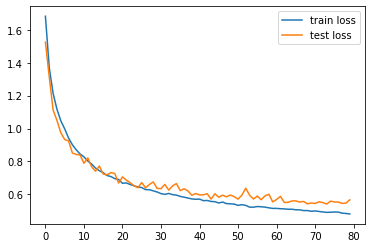

In [128]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader_fixed:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  
  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")